## Analysis for Fiber Photometry data
1. Date: Recording - 2024/05/15-16, Analysis - 2024/05/22-
2. Task: 3-Chamber test (E-E, S-E, S-S sessions)
3. Performer: Recording - YGKim, Analysis - YGKim
4. Animal: PV-Cre female and CHD8 WT/HT male 
5. Group, ID: as follows 

#### Experimental group info
PV-Cre Group 01</br>
**PV_F_G01_001** EE SE SS</br>
**PV_F_G01_002** EE SE SS</br>
**PV_F_G01_003** EE SE SS</br>
**PV_F_G01_004** EE SE SS</br></br>
PV-Cre Group 02</br>
**PV_F_G02_001** EE SE SS</br>
**PV_F_G02_002** EE SE SS</br>
**PV_F_G02_003** EE SE SS</br>
**PV_F_G02_004** EE</br> 
**PV_F_G02_005** EE</br></br>
CHD8 WT/HT</br>
**C8_M_WT_079** EE SE</br>
**C8_M_HT_710** EE SE</br>
**C8_M_HT_078** EE SE</br>
**C8_M_WT_089** EE SE</br>

### 0. Import libraries

In [137]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy.signal import medfilt, butter, filtfilt, find_peaks
from scipy.stats import linregress, f_oneway, ttest_ind 
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import auc #for calculating area under the curve 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib 
matplotlib.rcParams['font.size'] = 15 #set font size for all plots

### 1. Set file parameters and working dir 
Put everything that should be sepecified by user.

In [40]:
Base_folder = r'C:/Users/YGKim_IBS/Documents/GitHub/Jupyter_notebook/FiberPhotometry' 
Batch_folder = '240522_PV-Cre_CHD8' 
Animal_ID = 'PV_F_G01_003'
Session = 'SE'

FPS = 32 #Frame per second of behavior data
Duration_sec = 600 #Recording duration of behavior data
SavePlots = False
SaveData = False

Set working directory

In [41]:
cwd = os.path.join(Base_folder, Batch_folder, Animal_ID, Session)
if not os.path.exists(cwd):
        os.makedirs(cwd)
os.chdir(cwd)
os.getcwd()

'C:\\Users\\YGKim_IBS\\Documents\\GitHub\\Jupyter_notebook\\FiberPhotometry\\240522_PV-Cre_CHD8\\PV_F_G01_003\\SE'

### 2. Load data-sets

In [42]:
#Load preprocessed data from Fiber photometry recording
GCaMP_signal = pd.read_pickle(os.path.join(os.getcwd(),"Final_table.pkl"))
time_sec = GCaMP_signal.time
signal_dF_F = GCaMP_signal.value
GCaMP_signal

,original_time,time,value
0,7.012024,0.000328,9.848620
1,7.013007,0.001311,9.853167
2,7.013990,0.002294,9.857711
3,7.014973,0.003277,9.862253
4,7.015956,0.004260,9.866793
...,...,...,...
611162,607.808705,600.797008,0.738672
611163,607.809688,600.797991,0.738674
611164,607.810671,600.798974,0.738676
611165,607.811654,600.799957,0.738678


In [43]:
#Load postprocessed data from DeepLabCut analysis 
df_EVT = pd.read_csv('Data_DLC.csv', header=0, index_col=0)
df_EVT.head()

,Nose_x,Nose_y,Head_x,Head_y,roi,transition_index,N_s1_dist,NosePoke,NHaxis_angle,Heading_2_Szone,distance,approaching,EVT1,EVT2,EVT3
0,554.071899,225.541412,554.071899,225.541412,S,NaN,NaN,NaN,102.492864,False,107.813346,False,NaN,1.0,NaN
1,554.071899,225.541412,554.071899,225.541412,S,NaN,28.381314,on,102.373983,False,107.813346,False,NaN,NaN,NaN
2,554.133118,225.541412,554.133118,225.541412,S,NaN,29.292385,on,101.934778,False,107.787281,True,NaN,NaN,NaN
3,554.133118,223.817383,554.133118,223.817383,S,NaN,30.057711,off,100.882186,False,106.229665,True,NaN,NaN,NaN
4,554.877808,223.552460,554.877808,223.552460,S,NaN,29.353718,on,100.851005,False,105.670643,True,NaN,NaN,NaN


In [44]:
df_EVT[df_EVT.EVT1==1.0]

,Nose_x,Nose_y,Head_x,Head_y,roi,transition_index,N_s1_dist,NosePoke,NHaxis_angle,Heading_2_Szone,distance,approaching,EVT1,EVT2,EVT3
28,557.643250,223.225433,557.643250,223.225433,S,NaN,29.688632,on,110.219087,False,104.220811,True,1.0,NaN,NaN
271,498.349579,193.991150,498.349579,193.991150,S,NaN,26.549615,on,164.236365,False,121.192574,True,1.0,NaN,NaN
516,467.001831,157.355042,467.001831,157.355042,S,NaN,23.151106,on,171.618672,False,136.199234,True,1.0,NaN,NaN
843,524.990051,232.372910,524.990051,232.372910,S,NaN,27.414493,on,191.354312,False,128.530917,False,1.0,NaN,NaN
1521,535.455078,263.567841,535.455078,263.567841,S,0.0,27.429860,on,109.853773,False,150.148881,True,1.0,1.0,NaN
1919,526.551575,257.202789,526.551575,257.202789,S,NaN,28.922827,on,221.990209,False,148.620429,True,1.0,NaN,NaN
2026,544.547546,229.445419,544.547546,229.445419,S,NaN,10.558781,on,144.185034,False,115.612057,False,1.0,NaN,NaN
3507,564.882568,256.005219,564.882568,256.005219,S,NaN,28.041835,on,185.188193,False,132.734961,True,1.0,NaN,NaN
4329,528.277039,223.714523,528.277039,223.714523,S,NaN,21.412083,on,85.443270,False,119.605406,True,1.0,NaN,NaN
5062,582.952148,262.063049,582.952148,262.063049,S,NaN,29.832983,on,177.150676,False,135.142630,True,1.0,NaN,NaN


### 3. Analysis & Statistical testing

#### 3.1. Epoch averaging

##### 3.1.1. EVT1 Epoch averaging
The EVT1 is defined as a nose-poke event. To identify Nose-poke events, the nose of the subject animal and snout of the stimulus animal should be labeled correctly first. Then, three criteria were used. The distance between the nose and snout should be less than 30 pixels. In addition, Nose-poke event should have at least a minute-long duration. lastly, a valid nose-poke event shoulb be aparted at least 2 seconds from the previous event.   

In [45]:
# Generate time series of behavioral data
CamTickTime = np.linspace(0, Duration_sec, Duration_sec*FPS)

# First make a continous time series of social events
# Event1 index == 1이면 Nose-to-Snout interaction ON, Event1 index == 2이면 Nose-to-Snout interaction OFF.
if 'EVT1' in df_EVT.columns: 
    S_interaction_ON = np.array(CamTickTime[df_EVT.EVT1 == 1])
    S_interaction_OFF = np.array(CamTickTime[df_EVT.EVT1 == 2])

# Event2_index == 1이면 else -> S_zone으로 들어가고, EVT2 == 2이면 S_zone -> else으로 나감. 
S_zone_in = np.array(CamTickTime[df_EVT.EVT2 == 1]) 
# S_zone_in = np.insert(S_zone_in,0,CamTick[0]) #혹시 처음부터 S_zone에서 시작할 경우 Frame0의 EVT2 index를 임의로 조정.
S_zone_out = np.array(CamTickTime[df_EVT.EVT2 == 2]) 

# E-zone도 같은 방식으로 진행. EVT3 == 1이면 else -> E-zone, EVT3 == 2이면 E-zone -> else 
E_zone_in = np.array(CamTickTime[df_EVT.EVT3 == 1])
E_zone_out = np.array(CamTickTime[df_EVT.EVT3 == 2])

# S_zone_out, E_zone_in, E_zone_out

In [46]:
Evt_x = np.append(np.append(time_sec[0], np.reshape(np.kron([S_interaction_ON, S_interaction_OFF],
                   np.array([[1], [1]])).T, [1,-1])[0]), np.array(time_sec)[-1])
sz = len(S_interaction_ON)

CamTick = []

for i in range(len(S_interaction_ON)):
    CamTick.append(1)

# Create a vertical stack of arrays: two arrays of zeros('np.zeros(sz)') and two arrays of ones (d')
# Then, transpose the stacked array and reshaping it. 
# Append '0' at the start and end of the reshaped array
Evt_y = np.append(np.append(0, np.reshape(np.vstack([np.zeros(sz), CamTick, CamTick, np.zeros(sz)]).T, [1, -1])[0]), 0)

y_scale = 3
y_offset = -13

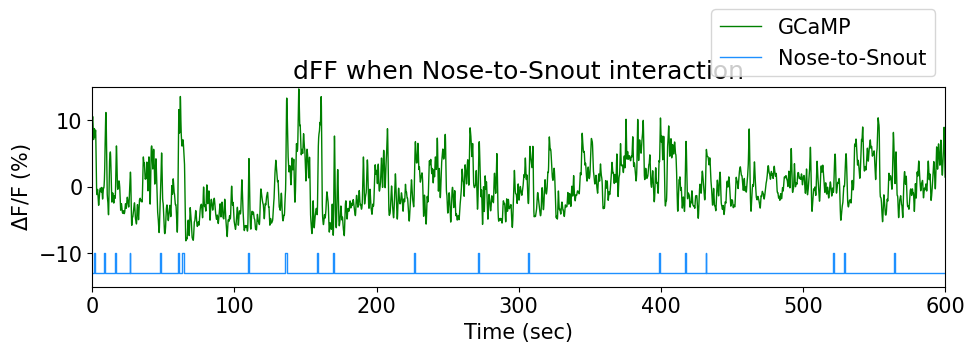

In [47]:
# First subplot in a series: dFF with social epocs
fig3 = plt.figure(figsize=(10,6))
ax2 = fig3.add_subplot(211)

p1, = ax2.plot(time_sec, signal_dF_F, label='GCaMP', linewidth=1, color='green')
p2, = ax2.plot(Evt_x, y_scale*Evt_y+y_offset, linewidth=1, color='dodgerblue', label='Nose-to-Snout')
ax2.set_ylim(-15, 15)
ax2.set_xlim(0, 600)
ax2.set_ylabel(r'$\Delta$F/F (%)')
ax2.set_xlabel('Time (sec)')
ax2.set_title('dFF when Nose-to-Snout interaction')
ax2.legend(handles=[p1,p2], loc='lower right', bbox_to_anchor=(1, 1))
fig3.tight_layout()

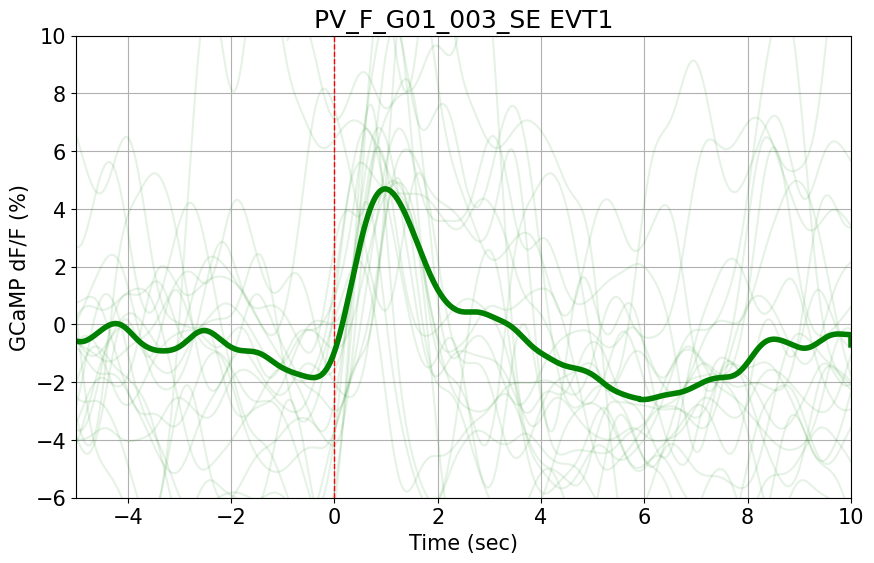

In [48]:
# 선택한 이벤트
EVTtype = 'EVT1'
selected_event = 1.0 # '1' means the onset time of the event.

# 선택한 이벤트에 해당하는 행 필터링
selected_events_data = df_EVT[df_EVT[EVTtype] == selected_event].copy() #SettingWithCopyWarning 참고 
selected_events_data['EVT_time'] = list((selected_events_data.index+1)/FPS)

# 그래프 생성
ax=plt.figure(figsize=(10, 6))


# 각 이벤트에 대해 데이터를 추출하고 lineplot으로 그림
all_lines = [] 

# start_time과 end_time을 저장할 변수 생성 
start_time_list = []
end_time_list = []

# 모든 line들을 저장하기 위한 리스트
for index, row in selected_events_data.iterrows():
    selected_event_time = row['EVT_time']

    # 이벤트 발생 시간을 기준으로 2초 전부터 3초 후까지의 데이터 추출
    start_time = selected_event_time - 5
    end_time = selected_event_time + 10
    filtered_data = GCaMP_signal[(GCaMP_signal['time'] >= start_time) & (GCaMP_signal['time'] <= end_time)]

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data = filtered_data.copy() #SettingWithCopyWarning 참고 
    filtered_data['time'] -= selected_event_time

    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    x_data = filtered_data['time']
    y_data = filtered_data['value']
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    all_lines.append(y_data.values)  # 각 시점에서의 데이터들을 저장
    start_time_list.append(start_time)
    end_time_list.append(end_time)

# 모든 시점에서의 데이터들을 2차원 배열로 변환
all_lines = pd.DataFrame(all_lines)
data = all_lines.to_numpy()

# start, end 시간을 2차원 배열로 변환 
df_TimeWindow = pd.DataFrame({'start' : start_time_list,
                             'end' : end_time_list})

# 각 시점에서의 데이터들의 평균값 계산
# mean_values = all_lines.mean(axis=0, numeric_only=False)
mean_values = np.nanmean(data, axis=0)
std_values = np.nanstd(data, axis=0)

min_length = min(len(mean_values), len(std_values))
x_data = (np.linspace(0, 15, min_length))-5

# 그래프 제목과 레이블 추가
plt.title(Animal_ID+'_'+Session+' '+EVTtype)
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# 범례 추가
# plt.legend()
plt.grid(True)
plt.xlim(-5, 10)
plt.ylim(-6, 10)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

if SavePlots == True:
    plt.savefig(f"Plot_Epoch_averaging_{EVTtype}_Mean+individual.png")

if SaveData==True:
    all_lines.to_pickle('Data_Extracted_signal_in_EVT1.pkl')
    df_TimeWindow.to_pickle('Data_TimeWindow_for_EVT1.pkl')


# 그래프 출력
plt.show()

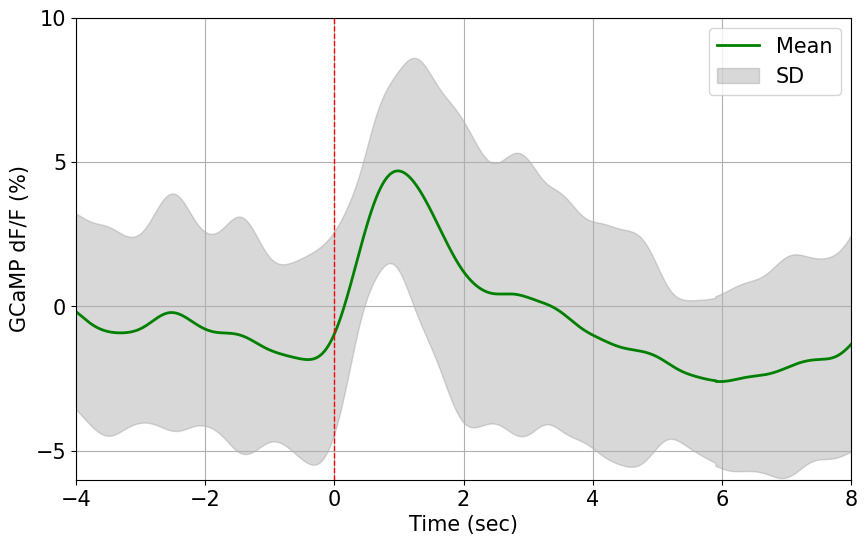

In [49]:
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot each time-series
# for i in range(data.shape[0]):
    # plt.plot(data[i, :], alpha=0.5, label=f'Series {i+1}')

# Plot the mean line
plt.plot(x_data,mean_values, color='g', linewidth=2, label='Mean')

# Plot the standard deviation area
plt.fill_between(
    x_data,
    mean_values - std_values,
    mean_values + std_values,
    color='gray',
    alpha=0.3,
    label='SD'
)

# Add labels and legend
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')
# plt.title(f'Epoch Averaging {EVTtype}')
plt.legend()
plt.grid()
plt.xlim(-4,8)
plt.ylim(-6, 10)
plt.yticks([-5, 0, 5, 10])
# plt.rc('axes', labelsize=30)
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)
# plt.rc('legend', fontsize=20)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

if SavePlots == True: 
    plt.savefig(f'Plot_epoch_averaging_{EVTtype}_Mean+SD.png')

# Show the plot
plt.show()

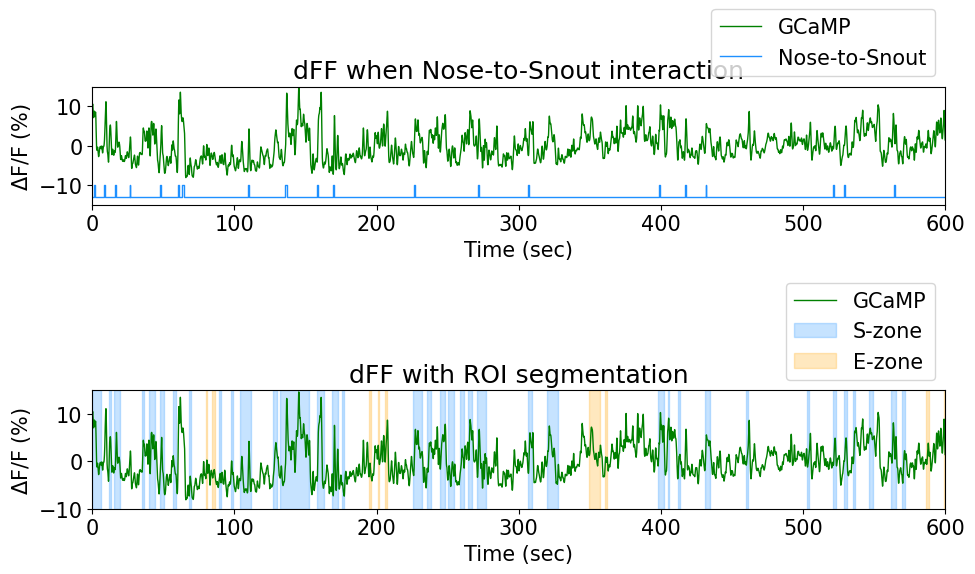

In [50]:
# Create the plot
# fig3 = plt.figure(figsize=(10,6))
ax3 = fig3.add_subplot(212)

# Create the line plot
p1, = ax3.plot(time_sec, signal_dF_F,linewidth=1, color='green', label='GCaMP')

# Add the vertical spnas using 'axvspan'.
for on, off in zip(S_zone_in, S_zone_out):
    ax3.axvspan(on, off, alpha=0.25, color='dodgerblue')
for on, off in zip(E_zone_in, E_zone_out):
    ax3.axvspan(on, off, alpha=0.25, color='orange')
ax3.set_ylim(-10, 15)
ax3.set_xlim(0, 600)
ax3.set_ylabel(r'$\Delta$F/F (%)')
ax3.set_xlabel('Time (sec)')
ax3.set_title('dFF with ROI segmentation')

# Create a custom legend for the vertical spans. 
handles, labels = ax3.get_legend_handles_labels()
handles.append(Patch(color='dodgerblue', alpha=0.25, label='S-zone'))
handles.append(Patch(color='orange', alpha=0.25, label='E-zone'))

ax3.legend(handles=handles, loc='lower right',bbox_to_anchor=(1, 1))

fig3.tight_layout()

if SavePlots == True: 
    plt.savefig('Plot_dFF_with_ROI_segmentation.png')

fig3

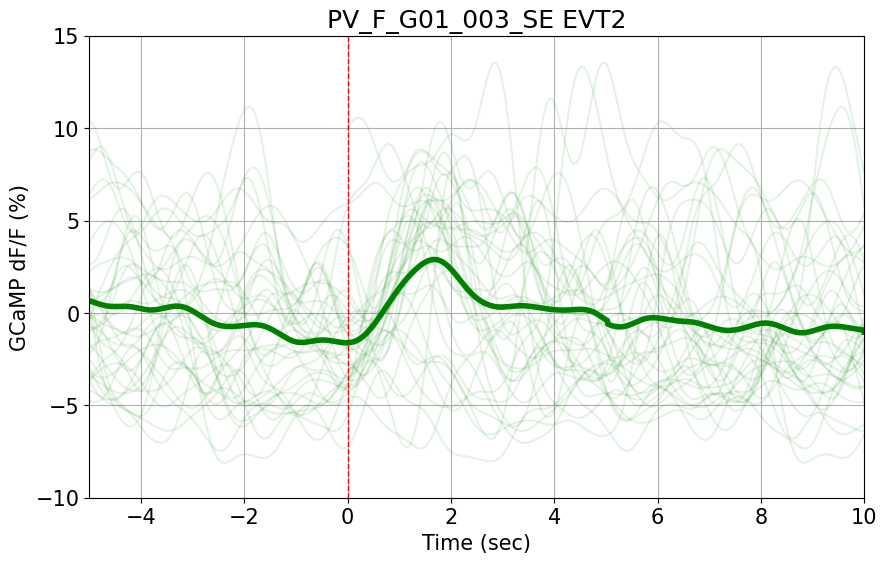

In [51]:
# 선택한 이벤트
EVTtype = 'EVT2'
selected_event = 1.0 # '1' means the onset time of the event.

# 선택한 이벤트에 해당하는 행 필터링
selected_events_data = df_EVT[df_EVT[EVTtype] == selected_event].copy() #SettingWithCopyWarning 참고 
selected_events_data['EVT_time'] = list((selected_events_data.index+1)/FPS)

# 그래프 생성
ax=plt.figure(figsize=(10, 6))


# 각 이벤트에 대해 데이터를 추출하고 lineplot으로 그림
all_lines2 = [] 

# start_time과 end_time을 저장할 변수 생성 
start_time_list = []
end_time_list = []


# 모든 line들을 저장하기 위한 리스트
for index, row in selected_events_data.iterrows():
    selected_event_time = row['EVT_time']

    # 이벤트 발생 시간을 기준으로 2초 전부터 3초 후까지의 데이터 추출
    start_time = selected_event_time - 5
    end_time = selected_event_time + 10
    filtered_data = GCaMP_signal[(GCaMP_signal['time'] >= start_time) & (GCaMP_signal['time'] <= end_time)]

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data = filtered_data.copy() #SettingWithCopyWarning 참고 
    filtered_data['time'] -= selected_event_time

    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    x_data = filtered_data['time']
    y_data = filtered_data['value']
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    all_lines2.append(y_data.values)  # 각 시점에서의 데이터들을 저장
    start_time_list.append(start_time)
    end_time_list.append(end_time)

# 모든 시점에서의 데이터들을 2차원 배열로 변환
all_lines2 = pd.DataFrame(all_lines2)
data2 = all_lines2.to_numpy()

# start, end 시간을 2차원 배열로 변환 
df_TimeWindow = pd.DataFrame({'start' : start_time_list,
                             'end' : end_time_list})

# 각 시점에서의 데이터들의 평균값 계산
# mean_values = all_lines.mean(axis=0, numeric_only=False)
mean_values = np.nanmean(data2, axis=0)
std_values = np.nanstd(data2, axis=0)

min_length = min(len(mean_values), len(std_values))
x_data = (np.linspace(0, 15, min_length))-5

# 그래프 제목과 레이블 추가
plt.title(Animal_ID+'_'+Session+' '+EVTtype)
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# 범례 추가
# plt.legend()
plt.grid(True)
plt.ylim(-10, 15)
plt.xlim(-5,10)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

if SavePlots == True:
    plt.savefig(f"Plot_Epoch_averaging_{EVTtype}_Mean+individual.png")

if SaveData==True:
    all_lines2.to_pickle(f'Data_Extracted_signal_in_{EVTtype}.pkl')
    df_TimeWindow.to_pickle(f'Data_TimeWindow_for_{EVTtype}.pkl')
    



# 그래프 출력
plt.show()

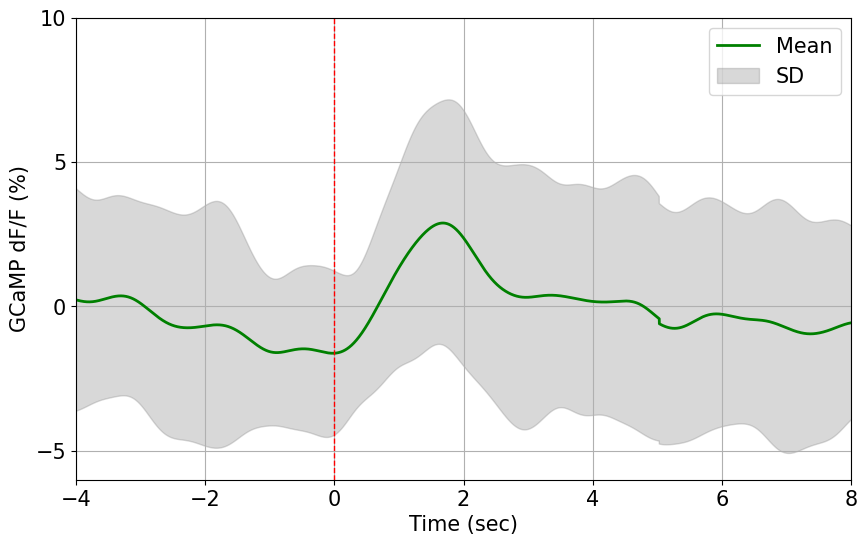

In [52]:
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot each time-series
# for i in range(data.shape[0]):
    # plt.plot(data[i, :], alpha=0.5, label=f'Series {i+1}')

# Plot the mean line
plt.plot(x_data,mean_values, color='g', linewidth=2, label='Mean')

# Plot the standard deviation area
plt.fill_between(
    x_data,
    mean_values - std_values,
    mean_values + std_values,
    color='gray',
    alpha=0.3,
    label='SD'
)

# Add labels and legend
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')
# plt.title('In-zone entry')
plt.legend()
plt.grid()
plt.xlim(-4,8)
plt.ylim(-6, 10)
plt.yticks([-5, 0, 5, 10])
# plt.rc('axes', labelsize=30)
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)
# plt.rc('legend', fontsize=20)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)


if SavePlots == True:
    plt.savefig(f"Plot_Epoch_averaging_{EVTtype}_Mean+SD.png")

# Show the plot
plt.show()

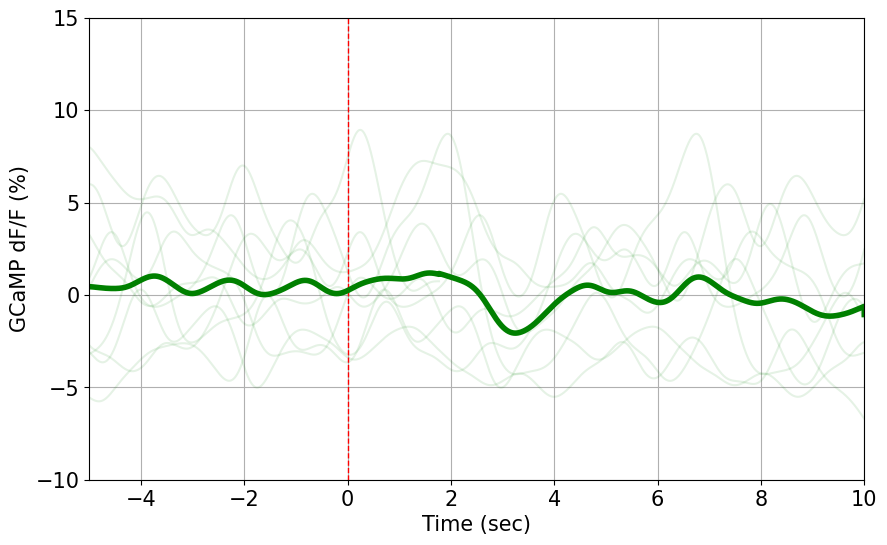

In [53]:
# 선택한 이벤트
EVTtype = 'EVT3'
selected_event = 1.0 # '1' means the onset time of the event.

# 선택한 이벤트에 해당하는 행 필터링
selected_events_data = df_EVT[df_EVT[EVTtype] == selected_event].copy() #SettingWithCopyWarning 참고 
selected_events_data['EVT_time'] = list((selected_events_data.index+1)/FPS)

# 그래프 생성
ax=plt.figure(figsize=(10, 6))


# 각 이벤트에 대해 데이터를 추출하고 lineplot으로 그림
all_lines3 = []  

# start_time과 end_time을 저장할 변수 생성 
start_time_list = []
end_time_list = []

# 모든 line들을 저장하기 위한 리스트
for index, row in selected_events_data.iterrows():
    selected_event_time = row['EVT_time']

    # 이벤트 발생 시간을 기준으로 2초 전부터 3초 후까지의 데이터 추출
    start_time = selected_event_time - 5
    end_time = selected_event_time + 10
    filtered_data = GCaMP_signal[(GCaMP_signal['time'] >= start_time) & (GCaMP_signal['time'] <= end_time)]

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data = filtered_data.copy() #SettingWithCopyWarning 참고 
    filtered_data['time'] -= selected_event_time

    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    x_data = filtered_data['time']
    y_data = filtered_data['value']
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    all_lines3.append(y_data.values)  # 각 시점에서의 데이터들을 저장
    start_time_list.append(start_time)
    end_time_list.append(end_time)


# 모든 시점에서의 데이터들을 2차원 배열로 변환
all_lines3 = pd.DataFrame(all_lines3)
data3 = all_lines3.to_numpy()

# start, end 시간을 2차원 배열로 변환 
df_TimeWindow = pd.DataFrame({'start' : start_time_list,
                             'end' : end_time_list})

# 각 시점에서의 데이터들의 평균값 계산
# mean_values = all_lines.mean(axis=0, numeric_only=False)
mean_values = np.nanmean(data3, axis=0)
std_values = np.nanstd(data3, axis=0)

min_length = min(len(mean_values), len(std_values))
x_data = (np.linspace(0, 15, min_length))-5

# 그래프 제목과 레이블 추가
# plt.title(Animal_ID+'_'+Session+' '+EVTtype)
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# plt.legend() # 범례 추가
plt.grid(True)
plt.ylim(-10, 15)
plt.xlim(-5, 10)
# plt.rc('axes', labelsize=30)
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

if SavePlots == True:
    plt.savefig(f"Plot_Epoch_averaging_{EVTtype}_Mean+individual.png")

if SaveData==True:
    all_lines3.to_pickle(f'Data_Extracted_signal_in_{EVTtype}.pkl')
    df_TimeWindow.to_pickle(f'Data_TimeWindow_for_{EVTtype}.pkl')

# 그래프 출력
plt.show()

In [54]:
all_lines2.shape

(37, 15259)

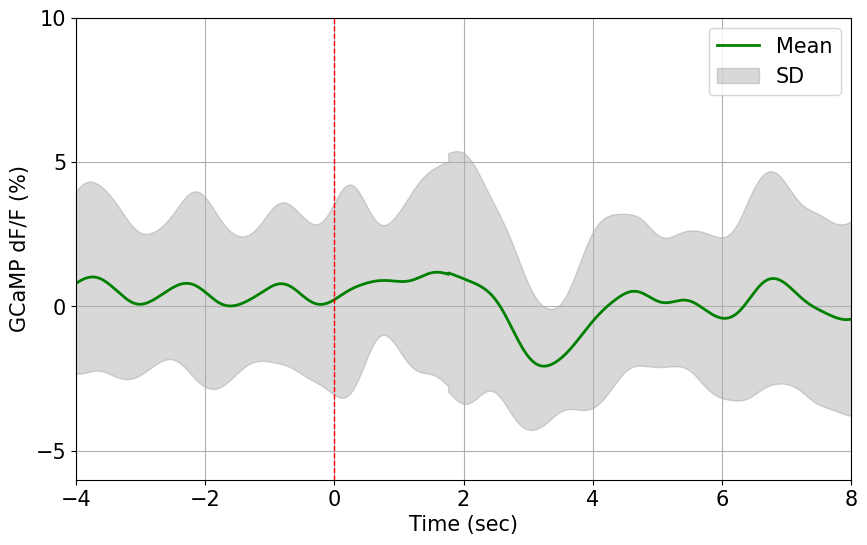

In [55]:
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot each time-series
# for i in range(data.shape[0]):
    # plt.plot(data[i, :], alpha=0.5, label=f'Series {i+1}')

# Plot the mean line
plt.plot(x_data,mean_values, color='g', linewidth=2, label='Mean')

# Plot the standard deviation area
plt.fill_between(
    x_data,
    mean_values - std_values,
    mean_values + std_values,
    color='gray',
    alpha=0.3,
    label='SD'
)

# Add labels and legend
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')
# plt.title(f'Epoch Averaging {EVTtype}')
plt.legend()
plt.grid()
plt.xlim(-4,8)
plt.ylim(-6, 10)
plt.yticks([-5, 0, 5, 10])
# plt.rc('axes', labelsize=30)
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)
# plt.rc('legend', fontsize=20)
plt.axvline(x=0, color = "red", linestyle = '--', linewidth = 1)

if SavePlots == True:
    plt.savefig(f"Plot_Epoch_averaging_{EVTtype}_Mean+SD.png")

# Show the plot
plt.show()

In [98]:
df.iloc[:, indice].shape[0]

25

4.693148577814511
1.3487963163552261
0.8668940513531734
0.24649649566838863
0.8839177375780346


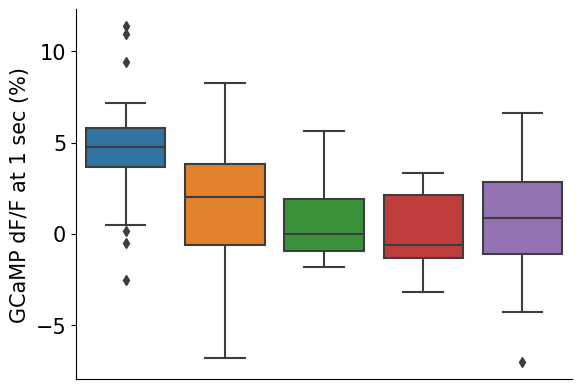

In [144]:
EVTn = [os.path.join(os.getcwd(), 'Data_Extracted_signal_in_EVT1.pkl'), 
        os.path.join(os.getcwd(), 'Data_Extracted_signal_in_EVT2.pkl'), 
        os.path.join(os.getcwd(), 'Data_Extracted_signal_in_EVT3.pkl'),
        'C:/Users/YGKim_IBS/Documents/GitHub/Jupyter_notebook/FiberPhotometry/240522_PV-Cre_CHD8/PV_F_G01_003/EE/Data_Extracted_signal_in_EVT2.pkl',
        'C:/Users/YGKim_IBS/Documents/GitHub/Jupyter_notebook/FiberPhotometry/240522_PV-Cre_CHD8/PV_F_G01_003/EE/Data_Extracted_signal_in_EVT3.pkl']

EVTname = ['[S-E] Nose-to-Snout', '[S-E] S-zone entry', '[S-E] E-zone entry', '[E-E] S-zone entry', '[E-E] E-zone entry']

EVT_list = []
Point_list = []

for i in range(len(EVTn)): 
    
    df = pd.read_pickle(EVTn[i])
    
    globals()['mean_EVT' + str(i+1)] = np.array(df.mean())
    globals()['sem_EVT' + str(i+1)] = np.array(df.sem())
    
    x_data = (np.linspace(0, 15, 15259))-5

    indice = np.min(np.where(x_data >= 1.00))
    globals()['point_EVT' + str(i+1)] = df.iloc[:, indice]
    x = EVTname[i] 
    EVTnamelist =  list(np.repeat(x, df.iloc[:, indice].shape[0], axis=0))
    Pointlist = list(df.iloc[:, indice])

    EVT_list += EVTnamelist
    Point_list += Pointlist

    print(globals()['point_EVT' + str(i+1)].mean())

df_point_name = pd.DataFrame({'dF/F_@_1s': Point_list, 
                         'EVT_name': EVT_list})

model = ols("Q('dF/F_@_1s') ~ C(EVT_name)", df_point_name).fit()
anova_lm(model)

ax = sns.boxplot(data=df_point_name, x='EVT_name', y='dF/F_@_1s')
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_ylabel("GCaMP dF/F at 1 sec (%)")
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(bottom=False)

In [138]:
model = ols("Q('dF/F_@_1s') ~ C(EVT_name)", df_point_name).fit()
print(anova_lm(model))
from statsmodels.sandbox.stats.multicomp import MultiComparison
comp = MultiComparison(df_point_name['dF/F_@_1s'], df_point_name['EVT_name'])
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "bonf", )
print(tbl)
tbl2 = comp.tukeyhsd()
print(tbl2.summary())

                df       sum_sq    mean_sq         F    PR(>F)
C(EVT_name)    4.0   238.253154  59.563288  5.777345  0.000315
Residual     101.0  1041.290050  10.309802       NaN       NaN
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.005
       group1              group2         stat   pval  pval_corr reject
-----------------------------------------------------------------------
 [E-E] E-zone entry  [E-E] S-zone entry  0.6826  0.499       1.0  False
 [E-E] E-zone entry  [S-E] E-zone entry  0.0146 0.9884       1.0  False
 [E-E] E-zone entry [S-E] Nose-to-Snout -3.8185 0.0004    0.0043   True
 [E-E] E-zone entry  [S-E] S-zone entry -0.5333 0.5958       1.0  False
 [E-E] S-zone entry  [S-E] E-zone entry -0.6213 0.5408       1.0  False
 [E-E] S-zone entry [S-E] Nose-to-Snout -4.2433 0.0002    0.0017   True
 [E-E] S-zone entry  [S-E] S-zone entry -1.1217 0.2674       1.0  False
 [S-E] E-zone entry [S-E] Nose-to-Snout -2.9179  0.007    0.0702  Fals

AttributeError: module 'pylab' has no attribute 'spines'

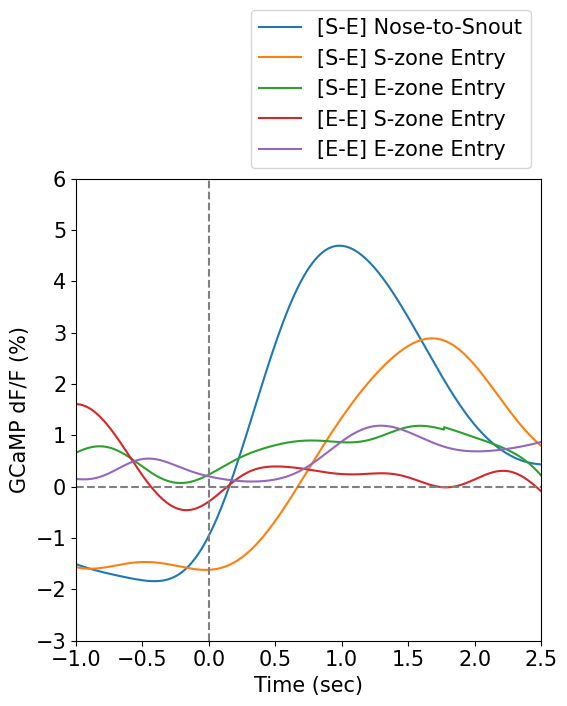

In [143]:
# 그래프 생성
ax=plt.figure(figsize=(6, 6))

x_data = (np.linspace(0, 15, len(mean_EVT1)))-5

for i in range(len(EVTn)): 
    # indice = np.where((np.array(x_data)==1.25))
    # globals()['mean_'+str(EVT)][indice]))
    line, = plt.plot(x_data, globals()['mean_' + 'EVT' + str(i+1)])
    # plt.fill_between(x_data, 
    #                  globals()['mean_' + 'EVT' + str(i+1)] - globals()['sem_' + 'EVT' + str(i+1)], 
    #                  globals()['mean_' + 'EVT' + str(i+1)] + globals()['sem_' + 'EVT' + str(i+1)],
    #                  color='grey', 
    #                  alpha=0.06)

# Add labels and legend
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')
# plt.title(f'Epoch Averaging {EVTtype}')
plt.legend(['[S-E] Nose-to-Snout', '[S-E] S-zone Entry','[S-E] E-zone Entry', '[E-E] S-zone Entry', '[E-E] E-zone Entry'], 
           loc='lower right',
           bbox_to_anchor=(1, 1))
# plt.grid()
plt.xlim(-1,2.5)
plt.ylim(-3, 6)
plt.axvline(x=0, color='grey', linestyle='--')
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()